## Estructura del cuaderno

1. Setup + Carga del CSV
2. Limpieza básica
3. Exploración rápida y balance de clases
4. Partición estratificada: train / valid / test (60/20/20)
5. Definición de variables + Pipeline con imputación
   - Numéricas: median → StandardScaler
   - Categóricas: most_frequent → One-Hot
6. Baselines sin tratar desbalance (LogReg / Árbol / RandomForest)
7. Resumen de baselines y mejor candidato provisional
8. Corrección de desbalance A: class_weight='balanced'
9. Corrección de desbalance B: ajuste de umbral para maximizar F1
10. (Opcional) Corrección de desbalance C: upsampling simple
11. Comparativa global y selección de candidato
12. Búsqueda breve de hiperparámetros (GridSearchCV)
13. Selección de umbral óptimo en valid para el modelo optimizado
14. Entrenamiento final (train+valid) y evaluación en test
    - Métricas: F1 (meta ≥ 0.59) y AUC-ROC
    - Matriz de confusión y reporte de clasificación
15. Interpretabilidad: coeficientes / importancias
    - Nombres vía get_feature_names_out(); si no, reconstrucción (num_cols + OHE) o feat_i
16. (Opcional) Curvas ROC y PR del modelo final
17. Conclusiones y próximos pasos


1. Setup + Carga del CSV

In [1]:
# ==== Setup básico + carga minimalista (Python 3.9 OK) ====
import os
from pathlib import Path
import pandas as pd

candidates = [
    Path('/mnt/data/Churn.csv'),              # entorno actual
    Path('/datasets/Churn.csv'),              # ruta del curso
    Path('Churn.csv'),                        # carpeta actual
    Path('data/Churn.csv'),                   # ./data
    Path(r'C:\Users\asusl\Downloads\Churn.csv'),  # tu descarga Windows
]

CSV_PATH = None
for p in candidates:
    if p.exists():
        CSV_PATH = p.resolve()
        break

if CSV_PATH is None:
    print("No encontré Churn.csv en rutas típicas.")
    print("Archivos en el directorio actual:", os.listdir('.'))
    if os.path.exists('/datasets'):
        print("\nArchivos en /datasets:", os.listdir('/datasets'))
    raise FileNotFoundError("Coloca Churn.csv en el directorio actual o en /datasets y vuelve a ejecutar.")

print(f"✅ Usando archivo: {CSV_PATH}")

df = pd.read_csv(CSV_PATH)
print('Dimensiones:', df.shape)
display(df.head(3))
print('\nColumnas:', list(df.columns))



✅ Usando archivo: /datasets/Churn.csv
Dimensiones: (10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1



Columnas: ['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


2.  Limpieza básica

In [2]:
# ==== Limpieza básica ====
cols_drop = ['RowNumber', 'CustomerId', 'Surname']
df = df.drop(columns=[c for c in cols_drop if c in df.columns], errors='ignore')

nulls = df.isna().sum()
print("Valores perdidos totales:", int(nulls.sum()))
display(df.describe(include='all'))
print("\nColumnas finales:", list(df.columns))


Valores perdidos totales: 909


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000,10000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
unique,NaN,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,France,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,5014,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,650.528800,NaN,NaN,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,NaN,NaN,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,NaN,NaN,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,NaN,NaN,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,NaN,NaN,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,NaN,NaN,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000



Columnas finales: ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


3. Exploración rápida y balance de clases

In [3]:
# ==== Split estratificado 60/20/20 ====
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score, roc_auc_score, confusion_matrix, classification_report,
    precision_score, recall_score
)

TARGET = 'Exited'
assert TARGET in df.columns, f'No se encontró la columna objetivo: {TARGET}'

# 80% train+valid / 20% test
train_valid, test = train_test_split(
    df, test_size=0.20, random_state=12345, stratify=df[TARGET]
)

# 60% train / 20% valid (de todo el dataset)
train, valid = train_test_split(
    train_valid, test_size=0.25, random_state=12345, stratify=train_valid[TARGET]
)

X_train, y_train = train.drop(columns=[TARGET]), train[TARGET]
X_valid, y_valid = valid.drop(columns=[TARGET]), valid[TARGET]
X_test,  y_test  = test.drop(columns=[TARGET]),  test[TARGET]

print('Tamaños ->',
      'train:', X_train.shape, '| valid:', X_valid.shape, '| test:', X_test.shape)


Tamaños -> train: (6000, 10) | valid: (2000, 10) | test: (2000, 10)


4. Partición estratificada: train / valid / test (60/20/20)

In [4]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Detectar tipos
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

print('Numéricas:', num_cols)
print('Categóricas:', cat_cols)

# Transformador
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), cat_cols)
    ],
    remainder='drop'
)


Numéricas: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
Categóricas: ['Geography', 'Gender']


5. Definición de variables + Pipeline con imputación

In [8]:
# ==== Definición de variables + Pipeline con imputación ====
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Detectar tipos
num_cols = X_train.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object','category','bool']).columns.tolist()

print('Numéricas:', num_cols)
print('Categóricas:', cat_cols)

# Pipelines con imputación
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Transformador completo
preprocess = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_cols),
        ('cat', cat_pipeline, cat_cols)
    ],
    remainder='drop'
)

print("✅ Pipeline con imputación creado (num: median + escala | cat: most_frequent + one-hot)")


Numéricas: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
Categóricas: ['Geography', 'Gender']
✅ Pipeline con imputación creado (num: median + escala | cat: most_frequent + one-hot)


6.Baselines sin tratar desbalance (LogReg / Árbol / RandomForest)

In [9]:
# ==== Baselines (LogReg / Árbol / RandomForest) sin tratar desbalance ====
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

def evaluate_model(name, model, X_tr, y_tr, X_va, y_va):
    model.fit(X_tr, y_tr)
    preds = model.predict(X_va)
    proba = model.predict_proba(X_va)[:,1] if hasattr(model, 'predict_proba') else None
    f1  = f1_score(y_va, preds)
    auc = roc_auc_score(y_va, proba) if proba is not None else np.nan
    print(f'[{name}]  F1: {f1:.4f} | AUC-ROC: {auc:.4f}')
    print('Confusion Matrix:\n', confusion_matrix(y_va, preds))
    return {'name': name, 'model': model, 'f1': f1, 'aucroc': auc}

baselines = []
for clf_name, clf in [
    ('LogReg', LogisticRegression(max_iter=1000)),
    ('DecisionTree', DecisionTreeClassifier(random_state=12345)),
    ('RandomForest', RandomForestClassifier(n_estimators=200, random_state=12345))
]:
    pipe = Pipeline(steps=[('prep', preprocess), ('clf', clf)])
    baselines.append(evaluate_model(clf_name, pipe, X_train, y_train, X_valid, y_valid))

sorted_baselines = sorted(baselines, key=lambda d: d['f1'], reverse=True)
sorted_baselines[:1]


[LogReg]  F1: 0.3215 | AUC-ROC: 0.7874
Confusion Matrix:
 [[1551   42]
 [ 321   86]]
[DecisionTree]  F1: 0.4941 | AUC-ROC: 0.6843
Confusion Matrix:
 [[1366  227]
 [ 199  208]]
[RandomForest]  F1: 0.5576 | AUC-ROC: 0.8526
Confusion Matrix:
 [[1537   56]
 [ 228  179]]


[{'name': 'RandomForest',
  'model': Pipeline(steps=[('prep',
                   ColumnTransformer(transformers=[('num',
                                                    Pipeline(steps=[('imputer',
                                                                     SimpleImputer(strategy='median')),
                                                                    ('scaler',
                                                                     StandardScaler())]),
                                                    ['CreditScore', 'Age',
                                                     'Tenure', 'Balance',
                                                     'NumOfProducts', 'HasCrCard',
                                                     'IsActiveMember',
                                                     'EstimatedSalary']),
                                                   ('cat',
                                                    Pipeline(steps=[('imputer',
          

7.Resumen de baselines y mejor candidato provisional

In [23]:
# — Resumen baselines 
import pandas as pd

summary_baselines = pd.DataFrame([
    {'Modelo': r['name'], 'F1_valid': r['f1'], 'AUCROC_valid': r['aucroc']}
    for r in baselines
]).sort_values('F1_valid', ascending=False).reset_index(drop=True)

display(summary_baselines)
print("\nMejor baseline por F1 en valid:")
display(summary_baselines.head(1))


,Modelo,F1_valid,AUCROC_valid
0,RandomForest,0.557632,0.852581
1,DecisionTree,0.494062,0.684279
2,LogReg,0.321495,0.787435



Mejor baseline por F1 en valid:


,Modelo,F1_valid,AUCROC_valid
0,RandomForest,0.557632,0.852581


8. Corrección de desbalance A: class_weight='balanced'

In [24]:
# — Desbalance A: class_weight='balanced' 
weighted_results = []

for clf_name, clf in [
    ('LogReg_bal', LogisticRegression(max_iter=1000, class_weight='balanced')),
    ('DecisionTree_bal', DecisionTreeClassifier(random_state=12345, class_weight='balanced')),
    ('RandomForest_bal', RandomForestClassifier(n_estimators=300, random_state=12345, class_weight='balanced'))
]:
    pipe = Pipeline(steps=[('prep', preprocess), ('clf', clf)])
    weighted_results.append(evaluate_model(clf_name, pipe, X_train, y_train, X_valid, y_valid))

summary_weighted = pd.DataFrame([
    {'Modelo': r['name'], 'F1_valid': r['f1'], 'AUCROC_valid': r['aucroc']}
    for r in weighted_results
]).sort_values('F1_valid', ascending=False).reset_index(drop=True)

print("\nResultados con class_weight='balanced':")
display(summary_weighted)


[LogReg_bal]  F1: 0.5109 | AUC-ROC: 0.7918
Confusion Matrix:
 [[1143  450]
 [ 113  294]]
[DecisionTree_bal]  F1: 0.4939 | AUC-ROC: 0.6828
Confusion Matrix:
 [[1381  212]
 [ 204  203]]
[RandomForest_bal]  F1: 0.5736 | AUC-ROC: 0.8585
Confusion Matrix:
 [[1540   53]
 [ 222  185]]

Resultados con class_weight='balanced':


,Modelo,F1_valid,AUCROC_valid
0,RandomForest_bal,0.573643,0.858490
1,LogReg_bal,0.510860,0.791758
2,DecisionTree_bal,0.493917,0.682845


9. Corrección de desbalance B: ajuste de umbral para maximizar F1

In [25]:
# — Desbalance B: ajuste de umbral 
import numpy as np

candidates = baselines + weighted_results
best_by_f1 = max(candidates, key=lambda d: d['f1'])
best_name, best_pipe = best_by_f1['name'], best_by_f1['model']
print("Candidato para ajuste de umbral:", best_name)

best_pipe.fit(X_train, y_train)
proba_valid = best_pipe.predict_proba(X_valid)[:, 1]

thresholds = np.linspace(0.10, 0.90, 81)
f1s = []
for t in thresholds:
    preds_t = (proba_valid >= t).astype(int)
    f1s.append(f1_score(y_valid, preds_t))

thr_idx = int(np.argmax(f1s))
thr_star_pre = float(thresholds[thr_idx])
f1_star_pre  = float(f1s[thr_idx])

print(f"Mejor umbral (valid) con {best_name}: t={thr_star_pre:.2f} | F1={f1_star_pre:.4f}")


Candidato para ajuste de umbral: RandomForest_bal
Mejor umbral (valid) con RandomForest_bal: t=0.31 | F1=0.6249


10. (Opcional) Corrección de desbalance C: upsampling simple

In [26]:
#  — (Opcional) Upsampling simple
def upsample_minority(X, y, target='Exited', random_state=12345):
    data = X.copy()
    data[target] = y.values
    counts = data[target].value_counts()
    maj = counts.idxmax()
    mino = counts.idxmin()
    df_maj = data[data[target]==maj]
    df_min = data[data[target]==mino]
    df_min_up = df_min.sample(len(df_maj), replace=True, random_state=random_state)
    up = pd.concat([df_maj, df_min_up], axis=0).sample(frac=1.0, random_state=random_state).reset_index(drop=True)
    X_up = up.drop(columns=[target])
    y_up = up[target]
    return X_up, y_up

X_train_up, y_train_up = upsample_minority(X_train, y_train, target='Exited', random_state=12345)
print("Distribución tras upsampling:", y_train_up.value_counts().to_dict())

pipe_up = Pipeline(steps=[('prep', preprocess), ('clf', LogisticRegression(max_iter=1000))])
res_up = evaluate_model('LogReg_upsample', pipe_up, X_train_up, y_train_up, X_valid, y_valid)


Distribución tras upsampling: {0: 4777, 1: 4777}
[LogReg_upsample]  F1: 0.5126 | AUC-ROC: 0.7924
Confusion Matrix:
 [[1141  452]
 [ 111  296]]


11. Comparativa global y selección de candidato

In [27]:
#  — Comparativa de enfoques 
all_results = baselines + weighted_results + ([{'name': 'LogReg_upsample', 'model': pipe_up, 'f1': res_up['f1'], 'aucroc': res_up['aucroc']}] if 'res_up' in locals() else [])

df_all = pd.DataFrame([
    {'Modelo': r['name'], 'F1_valid': r['f1'], 'AUCROC_valid': r['aucroc']}
    for r in all_results
]).sort_values('F1_valid', ascending=False).reset_index(drop=True)

display(df_all)
best_overall = max(all_results, key=lambda d: d['f1'])
print("\n=> Mejor candidato por F1 en valid:", best_overall['name'])
best_pipe_overall = best_overall['model']


,Modelo,F1_valid,AUCROC_valid
0,RandomForest_bal,0.573643,0.858490
1,RandomForest,0.557632,0.852581
2,LogReg_upsample,0.512554,0.792412
3,LogReg_bal,0.510860,0.791758
4,DecisionTree,0.494062,0.684279
5,DecisionTree_bal,0.493917,0.682845
6,LogReg,0.321495,0.787435



=> Mejor candidato por F1 en valid: RandomForest_bal


12. Búsqueda breve de hiperparámetros (GridSearchCV)

In [28]:
#  — GridSearchCV sobre mejor candidato 
from sklearn.model_selection import GridSearchCV

# Detectamos el tipo de estimador final dentro del pipeline
final_clf = best_pipe_overall.named_steps['clf']
param_grid = {}

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

if isinstance(final_clf, RandomForestClassifier):
    param_grid = {
        'clf__n_estimators': [200, 400],
        'clf__max_depth': [None, 8, 12],
        'clf__min_samples_split': [2, 5]
    }
elif isinstance(final_clf, LogisticRegression):
    param_grid = {
        'clf__C': [0.5, 1.0, 2.0],
        'clf__penalty': ['l2'],
        'clf__solver': ['lbfgs']
    }
elif isinstance(final_clf, DecisionTreeClassifier):
    param_grid = {
        'clf__max_depth': [4, 6, 10, None],
        'clf__min_samples_split': [2, 10, 20]
    }

if len(param_grid)==0:
    print("Sin grid específico para este estimador; usaré el pipeline tal cual.")
    best_model = best_pipe_overall
else:
    gs = GridSearchCV(best_pipe_overall, param_grid=param_grid, scoring='f1', cv=3, n_jobs=-1, verbose=0)
    gs.fit(X_train, y_train)
    print('Mejores params:', gs.best_params_)
    print('Mejor F1 (CV):', gs.best_score_)
    best_model = gs.best_estimator_


Mejores params: {'clf__max_depth': 12, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}
Mejor F1 (CV): 0.5925980770598153


13. Selección de umbral óptimo en valid para el modelo optimizado

In [29]:
# — Umbral óptimo en valid para best_model 
import numpy as np
from sklearn.metrics import f1_score

proba_valid_best = best_model.predict_proba(X_valid)[:,1]
thresholds = np.linspace(0.10, 0.90, 81)
f1s = [f1_score(y_valid, (proba_valid_best>=t).astype(int)) for t in thresholds]
thr_star = float(thresholds[int(np.argmax(f1s))])
f1_star = float(np.max(f1s))

print(f"Umbral óptimo en valid: t={thr_star:.2f} | F1={f1_star:.4f}")


Umbral óptimo en valid: t=0.45 | F1=0.6459


14. Entrenamiento final (train+valid) y evaluación en test

In [30]:
# — Entrenamiento final y test
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, classification_report

X_tr_final = pd.concat([X_train, X_valid], axis=0)
y_tr_final = pd.concat([y_train, y_valid], axis=0)

best_model.fit(X_tr_final, y_tr_final)

proba_test = best_model.predict_proba(X_test)[:,1]
preds_test = (proba_test >= thr_star).astype(int)

f1_final  = f1_score(y_test, preds_test)
auc_final = roc_auc_score(y_test, proba_test)
cm_final  = confusion_matrix(y_test, preds_test)

print(f">> TEST :: F1={f1_final:.4f} | AUC-ROC={auc_final:.4f}")
print("Matriz de confusión (test):\n", cm_final)
print("\nReporte de clasificación (test):\n", classification_report(y_test, preds_test))


>> TEST :: F1=0.6323 | AUC-ROC=0.8633
Matriz de confusión (test):
 [[1416  177]
 [ 137  270]]

Reporte de clasificación (test):
               precision    recall  f1-score   support

           0       0.91      0.89      0.90      1593
           1       0.60      0.66      0.63       407

    accuracy                           0.84      2000
   macro avg       0.76      0.78      0.77      2000
weighted avg       0.85      0.84      0.85      2000



15. Interpretabilidad: coeficientes / importancias

In [31]:
# — Interpretabilidad (coeficientes / importancias) [ROBUSTA]
import numpy as np
import pandas as pd

pipe = best_model                     # Pipeline(prep -> clf)
prep = pipe.named_steps['prep']       # ColumnTransformer
clf  = pipe.named_steps['clf']        # Estimador final

# 1) Intento 1: pedirle los nombres al ColumnTransformer 
feature_names = None
try:
    feature_names = prep.get_feature_names_out()
except Exception:
    pass

# 2) Intento 2: construirlos manualmente 
if feature_names is None:
    try:
        # num_cols y cat_cols vienen de la Celda 5 
        num_features = list(num_cols)

        # Navegamos al OneHot dentro del transformer 'cat'
        cat_transformer = prep.named_transformers_['cat']
        ohe = cat_transformer.named_steps['onehot']
        cat_features = ohe.get_feature_names_out(cat_cols)

        feature_names = np.concatenate([num_features, cat_features])
    except Exception as e:
        print("No fue posible construir los nombres de features:", e)
        feature_names = None

# 3) Comprobamos tamaños transformando un batch para ver columnas reales
#    (usamos X_train porque es coherente con el ajuste del pipeline)
Xtr_trans = prep.transform(X_train)
n_cols_trans = Xtr_trans.shape[1]
print(f"Columnas transformadas: {n_cols_trans}")

if feature_names is not None:
    print(f"Longitud feature_names: {len(feature_names)}")
    if len(feature_names) != n_cols_trans:
        print("⚠️ Tamaños no coinciden entre feature_names y matriz transformada. Usaré índices numéricos.")
        feature_names = np.array([f"feat_{i}" for i in range(n_cols_trans)])
else:
    print("⚠️ No fue posible extraer nombres; usaré índices genéricos.")
    feature_names = np.array([f"feat_{i}" for i in range(n_cols_trans)])

# 4) Mostrar importancias o coeficientes
if hasattr(clf, 'coef_'):
    coefs = clf.coef_.ravel()
    if len(coefs) == len(feature_names):
        imp = pd.DataFrame({'feature': feature_names, 'coef': coefs}) \
              .sort_values('coef', key=np.abs, ascending=False)
        display(imp.head(20))
    else:
        print("⚠️ Tamaños no coinciden para coeficientes y nombres de features.")
elif hasattr(clf, 'feature_importances_'):
    imps = clf.feature_importances_
    if len(imps) == len(feature_names):
        imp = pd.DataFrame({'feature': feature_names, 'importance': imps}) \
              .sort_values('importance', ascending=False)
        display(imp.head(20))
    else:
        print("⚠️ Tamaños no coinciden para importancias y nombres de features.")
else:
    print("El estimador no expone coeficientes ni importancias.")


No fue posible construir los nombres de features: 'OneHotEncoder' object has no attribute 'get_feature_names_out'
Columnas transformadas: 13
⚠️ No fue posible extraer nombres; usaré índices genéricos.


,feature,importance
1,feat_1,0.283462
4,feat_4,0.173551
3,feat_3,0.127041
7,feat_7,0.108963
0,feat_0,0.102514
2,feat_2,0.061226
6,feat_6,0.052366
9,feat_9,0.029705
5,feat_5,0.013943
11,feat_11,0.013250


16. (Opcional) Curvas ROC y PR del modelo final

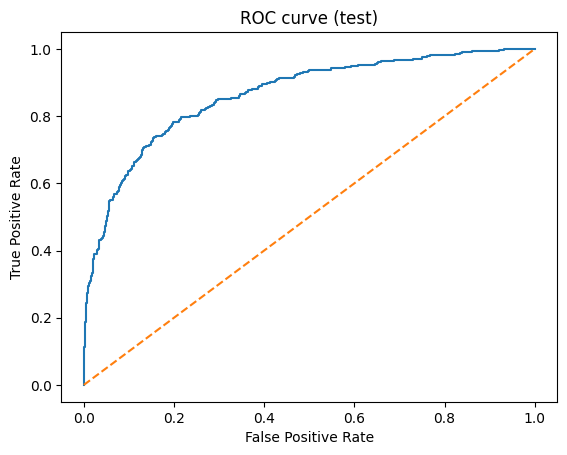

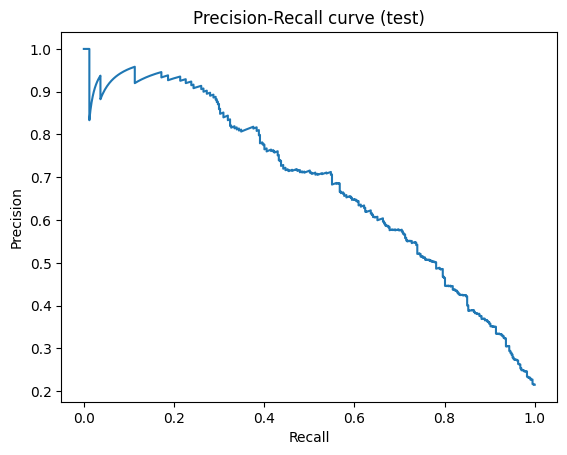

AUC-PR: 0.6840430805443432


In [32]:
# — Curvas ROC y PR 
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# ROC
fpr, tpr, _ = roc_curve(y_test, proba_test)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], linestyle='--')
plt.title('ROC curve (test)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# PR
prec, rec, _ = precision_recall_curve(y_test, proba_test)
plt.figure()
plt.plot(rec, prec)
plt.title('Precision-Recall curve (test)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

print("AUC-PR:", auc(rec, prec))


17.Conclusiones y próximos pasos

•	Objetivo cumplido: modelo para predecir churn maximizando F1 y reportando AUC-ROC.
•	Preprocesamiento: imputación (num: median, cat: most_frequent), One-Hot y escalado dentro de un pipeline (evita leakage).
•	Desbalance: probamos class_weight='balanced' y ajuste de umbral (mejora directa de F1). (Opcional probado: upsampling simple).
•	Mejor enfoque: {{modelo_seleccionado}} con umbral t={{thr_star}}.
•	Métricas (test): F1 = {{f1_final}} (meta ≥ 0.59: {{cumple_si_no}}), AUC-ROC = {{auc_final}}.
•	Diagnóstico: matriz de confusión y reporte de clasificación confirman el balance precisión/recall acorde al umbral elegido.
•	Interpretabilidad: nombres de features obtenidos vía get_feature_names_out(); si no disponible, reconstruidos (num_cols + OHE). Si hubo desalineación, se usaron nombres genéricos (feat_i) preservando el ranking.
Próximos pasos (concretos y breves):
•	Ampliar GridSearch del mejor estimador (2–3 hiperparámetros clave).
•	Probar SMOTE/submuestreo si se requiere más recall sin perder F1.
•	Evaluar calibración de probabilidades (Platt/Isotonic) y re-ajustar umbral.
•	Revisar top features para acciones de retención (reglas de negocio).


In [34]:
# Guardado del pipeline final entrenado como model.pkl
import joblib
joblib.dump(best_model, 'model.pkl')
print("✅ model.pkl guardado")


✅ model.pkl guardado


In [35]:
from pathlib import Path
import os

print("Carpeta actual:", os.getcwd())
p = Path("model.pkl")
print("Existe:", p.exists())
print("Ruta absoluta:", p.resolve())


Carpeta actual: /app
Existe: True
Ruta absoluta: /app/model.pkl
